In [1]:
import json
import sim
import collections
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from collections import defaultdict as dd
from os import listdir
from matplotlib import ticker

In [3]:
with open("results/thesis/mcmd_result_5_cht.txt", 'r', encoding='utf-8') as json_file:
    result = json.load(json_file)

In [7]:
res = {round(k,:v["im_gateways"] for k,v in result.items()}
res

{'0.2': ['778638', '778671', '778737', '778650', '778498'],
 '0.4': ['778638', '778671', '778737', '778650', '778498'],
 '0.6000000000000001': ['778638', '778671', '778650', '778737', '778498'],
 '0.8': ['778638', '778671', '778650', '778737', '778498'],
 '1.0': ['778638', '778671', '778650', '778737', '778498']}

In [ ]:
{'0.2': ['778638', '778671', '778737', '778650', '778498'],
 '0.4': ['778638', '778671', '778737', '778650', '778498'],
 '0.6000000000000001': ['778638', '778671', '778650', '778737', '778498'],
 '0.8': ['778638', '778671', '778650', '778737', '778498'],
 '1.0': ['778638', '778671', '778650', '778737', '778498']}

In [2]:
data = collections.defaultdict(list)
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5) #rc={"lines.linewidth": 2.5})
results_folder= "results/thesis/cht/budget"
#results_folder= "results/thesis/louisville/budget"
listdir(results_folder)

['celf',
 'cht.zip_data_1.txt',
 'cht.zip_data_3.txt',
 'cht.zip_data_2.txt',
 'betweenness',
 'cht.zip_data_6.txt',
 '.DS_Store',
 'indegree',
 'cht.zip_data_5.txt',
 'cht.zip_data_4.txt']

In [3]:
from collections import defaultdict
cities = defaultdict(dict)

for sub_folder in listdir(results_folder):
    
    if sub_folder=='.DS_Store':
        continue
        
    if not (sub_folder in ["celf", "indegree", "betweenness"]):#["betweenness", , "celf"]):
        continue
        
    print(sub_folder)
    dirr = "{0}/{1}/".format(results_folder,sub_folder)
    r = listdir(dirr)
    groups = {}
    linestrings = {}
    s_string = ""
    end1_start2 =dd(list)

    all_budgets = set()
    
    ons, ons_msgs, ons_wait_times, ons_route_times = defaultdict(list),defaultdict(list),defaultdict(list),defaultdict(list)
    total_generated, total_delivered = defaultdict(int),defaultdict(int)
    
    total_delay, delivered_gen, total_gen = defaultdict(int),defaultdict(int),defaultdict(int)
    
    for x in r[:]:
        if x=='.DS_Store':
            continue
        budget = int(x.split("_")[-3][6:])
        all_budgets.add(budget)
        
        
        with open(dirr + x, 'r', encoding='utf-8') as json_file:
             
            result = json.load(json_file)

            for d in result['ons']:
                l = np.array(d['all_latencies'], dtype=float)
                #for delay graph
                l[np.isnan(l)] = sim.upper_bound_delay
                median = np.nanmedian(l)
                mean = np.nanmean(l)
                temp = {
                        'Median Delay (minutes)': median /60,
                        'Median Delay (hours)': median /60/60,
                        'Mean Delay (minutes)': mean /60,
                        'mean Delay (hours)': mean /60/60,
                        'delivery_rate': d['delivery_rate']
                        }

                #print(budget)
                ons[budget].append(temp)
                ons_msgs[budget].extend([val/60 for val in l])


                for i in range(len(d['all_waiting_times'])):
                    ons_wait_times[budget].append(d['all_waiting_times'][i])
                    
                    if d['all_waiting_times'][i] == None:
                        ons_route_times[budget].append(None)
                    else: 
                        ons_route_times[budget].append(d['all_latencies'][i] - d['all_waiting_times'][i])
                        
                total_generated[budget] += len(d['all_gen_times'])
                total_delivered[budget] += len(d['delivered_gen_times'])
                
                total_delay[budget] += result['total_delay']
                delivered_gen[budget] += result['delivered_gen']
                total_gen[budget] = result['total_gen']


    all_budgets = sorted(list(all_budgets))
    for b in all_budgets:
        #print(b, np.nanmean(ons_msgs[b]))
        ons_msgs[b] = np.array(ons_msgs[b], dtype=float)
        ons_wait_times[b] = np.array(ons_wait_times[b], dtype=float)/60
        ons_route_times[b] = np.array(ons_route_times[b], dtype=float)/60

#     ons_msgs = [np.array(x, dtype=float) for x in ons_msgs]
#     ons_wait_times = [np.array(x, dtype=float)/60 for x in ons_wait_times]
#     ons_route_times = [np.array(x, dtype=float)/60 for x in ons_route_times]
    
    
#     ons_msgs = [np.array(x, dtype=float) for b in range(len(ons_msgs)) for x in ons_msgs[b]]
#     ons_wait_times = [[np.array(x, dtype=float)/60 for b in range(len(ons_wait_times))] for x in ons_wait_times[b]]
#     ons_route_times = [[np.array(x, dtype=float)/60 for b in range(len(ons_route_times))] for x in ons_route_times[b]]
    
    
    for b in all_budgets:
        cities[sub_folder][b] = {
            'ons': ons[b],
            'ons_msgs': ons_msgs[b],
            'ons_wait_times': ons_wait_times[b],
            'ons_route_times': ons_route_times[b],
            'df1': pd.DataFrame(ons[b]),
            'df2': pd.DataFrame(
                {
                    'wait_times': ons_wait_times[b],
                    'route_times': ons_route_times[b]
                }
            ),
            'total_generated': total_generated[b],
            'total_delivered': total_delivered[b],
            'total_delay': total_delay[b], 
            'delivered_gen': delivered_gen[b] ,
            'total_gen': total_gen[b]
        }
    

sns.set(font_scale=1.6, style="whitegrid") 
plt.subplots_adjust(hspace=0.35, wspace=0.2)

celf


/Users/shina/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1112: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Users/shina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


betweenness
indegree


<Figure size 432x288 with 0 Axes>

In [4]:
for k,v in cities.items():
    v["mean_budget_delays_per_sensor"] = []
    v["median_budget_delays_per_sensor"] = []
    v["mean_budget_delays"] = []
    v["median_budget_delays"] = []
    v["mean_delivery_rate_per_sensor"] = []
    v["cummulative_delivery_rate"] = []
    v["budget_delays"] = []
    
    v['total_mean_delay'] = []
    v['total_median_delay'] = []
    v['total_delivery_rate'] = []
        
#     total_delay = 0
#     total_generated = 0
#     total delivered = 0
    for b in all_budgets:
        v["mean_budget_delays_per_sensor"].append(np.nanmean(v[b]['df1']['Mean Delay (minutes)']))
        v["median_budget_delays_per_sensor"].append(np.nanmedian(v[b]['df1']['Median Delay (minutes)']))
        v["mean_budget_delays"].append(np.nanmean(v[b]['ons_msgs']))
        v["budget_delays"].append(v[b]['ons_msgs'])
        v["median_budget_delays"].append(np.nanmedian(v[b]['ons_msgs']))
        v["mean_delivery_rate_per_sensor"].append(np.nanmean(v[b]['df1']['delivery_rate']))
        v["cummulative_delivery_rate"].append(v[b]['total_delivered']/v[b]['total_generated'])
        
#         total_delay = 0
#         total_generated = 0
#         total delivered = 0
        
        v['total_mean_delay'].append(v[b]['total_delay'] / v[b]['total_gen'])
        v['total_median_delay'] = total_delay[b]
        v['total_delivery_rate'].append(v[b]['delivered_gen'] / v[b]['total_gen'])

#     print(k, v["mean_budget_delays_per_sensor"], v["median_budget_delays_per_sensor"])
#     print(v["mean_budget_delays"], v["median_budget_delays"])
#     print(v["median_delivery_rate_per_sensor"], v["cummulative_delivery_rate"])

In [5]:
cities["indegree"]["mean_budget_delays"]

[1180.895461792687,
 764.3541119693932,
 505.9832892737595,
 505.4331370804961,
 488.04602975224424,
 487.6143053691871,
 487.2165086886449,
 486.304290063568,
 485.39617288325815,
 468.02372254177857,
 467.3392925363046,
 467.2400459576605,
 467.1950735729455,
 467.167289936386,
 467.1499127015464]

[110.91073530169967, 68.47567580191657, 64.6632165488964, 59.12656760860458, 54.03009649924092, 53.958782518117445, 52.16826739507152, 51.108472509053904, 51.0973813420622, 50.723519935163765, 49.0973813420622, 49.03009649924092, 48.93866024332284, 48.84022864796346, 46.847457627118644]
[213.45864208261196, 211.06328051978133, 101.62004167613424, 101.23735823753287, 101.23735823753287, 101.23735823753287, 100.82208883553422, 96.38779894536043, 95.82917038358609, 95.82917038358609, 94.26326530612245, 94.26326530612245, 94.00556409800814, 93.98877916458932, 63.448618347708276]
[1560.0, 320.0190899594405, 80.47772306269016, 80.2874607833535, 77.7208819876189, 76.94444444444444, 76.75595238095238, 75.00557281737339, 72.77343652504717, 71.24703298954059, 69.96056446419182, 69.78518825370523, 69.66245921858837, 69.55798394290811, 69.46255842190631]


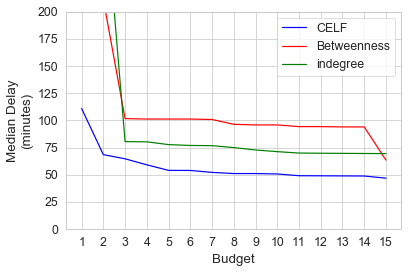

In [17]:
#plt.axes(figsize=(10,10))
sns.set_context("paper", font_scale=1.4) #rc={"lines.linewidth": 2.5})
algos = ['celf', 'betweenness', 'indegree']

x_axis = range(all_budgets[0], all_budgets[-1]+1)

#attribute = "mean_budget_delays_per_sensor"
#attribute = "median_budget_delays_per_sensor"
#attribute = "mean_budget_delays"
attribute = "median_budget_delays"
#attribute = "mean_delivery_rate_per_sensor"
#attribute = "cummulative_delivery_rate"
#attribute = "total_delivery_rate"
#attribute = "total_mean_delay"

y = cities["celf"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='blue', label="CELF")
print(y)

y = cities["betweenness"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='red', label="Betweenness")
print(y)

y = cities["indegree"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='green', label="indegree")
print(y)

# #x,y = process(closeness)
# #ax = sns.lineplot(x=x, y =y, color='purple', label="closeness")


#ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set(ylim=(0, 200))
ax.set_xlabel("Budget")
ax.set_ylabel("Median Delay\n(minutes)")
plt.savefig('budget_med_delay_cht.png', dpi=150)

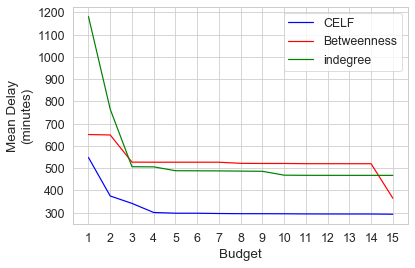

In [7]:
#plt.axes(figsize=(10,10))
sns.set_context("paper", font_scale=1.4) #rc={"lines.linewidth": 2.5})
algos = ['celf', 'betweenness', 'indegree']

x_axis = range(all_budgets[0], all_budgets[-1]+1)

#attribute = "mean_budget_delays_per_sensor"
#attribute = "median_budget_delays_per_sensor"
attribute = "mean_budget_delays"
#attribute = "median_budget_delays"
#attribute = "mean_delivery_rate_per_sensor"
#attribute = "cummulative_delivery_rate"
#attribute = "total_delivery_rate"
#attribute = "total_mean_delay"

y = cities["celf"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='blue', label="CELF")

y = cities["betweenness"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='red', label="Betweenness")

y = cities["indegree"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='green', label="indegree")

# #x,y = process(closeness)
# #ax = sns.lineplot(x=x, y =y, color='purple', label="closeness")


ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

ax.set_xlabel("Budget")
ax.set_ylabel("Mean Delay\n(minutes)")
plt.savefig('budget_mean_delay_cht.png', dpi=150)

NameError: name 'tips' is not defined

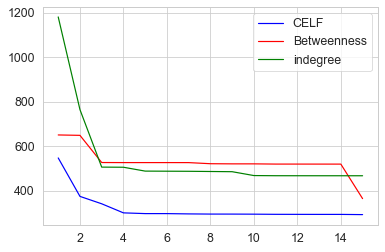

In [8]:
#plt.axes(figsize=(10,10))
sns.set_context("paper", font_scale=1.4) #rc={"lines.linewidth": 2.5})
algos = ['celf', 'betweenness', 'indegree']

x_axis = range(all_budgets[0], all_budgets[-1]+1)

y = cities["celf"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='blue', label="CELF")

y = cities["betweenness"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='red', label="Betweenness")

y = cities["indegree"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='green', label="indegree")

# #x,y = process(closeness)
# #ax = sns.lineplot(x=x, y =y, color='purple', label="closeness")

sns.boxplot(x=x_axis, y="budget_delays",
            hue="smoker", palette=["m", "g"],
            data=tips)
sns.despine(offset=10, trim=True)

# #ax.yaxis.set_major_locator(ticker.MultipleLocator(250))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.set_xlabel("Budget")
# ax.set_ylabel("Mean Delay\n(minutes)")
# plt.savefig('budget_mean_delay_cht.png', dpi=150)

In [44]:
sns.boxplot??

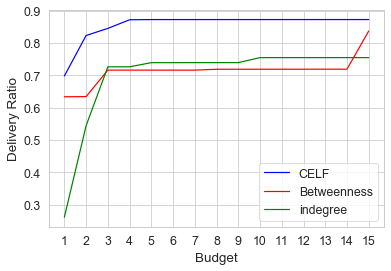

In [43]:
#plt.figure(figsize=(10,10))
algos = ['celf', 'betweenness', 'indegree']

x_axis = range(all_budgets[0], all_budgets[-1]+1)

#attribute = "mean_budget_delays_per_sensor"
#attribute = "median_budget_delays_per_sensor"
#attribute = "mean_budget_delays"
#attribute = "median_budget_delays"
#attribute = "mean_delivery_rate_per_sensor"
attribute = "cummulative_delivery_rate"
#attribute = "total_delivery_rate"
#attribute = "total_mean_delay"

y = cities["celf"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='blue', label="CELF")

y = cities["betweenness"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='red', label="Betweenness")

y = cities["indegree"][attribute]
ax = sns.lineplot(x=x_axis, y =y, color='green', label="indegree")

# #x,y = process(closeness)
# #ax = sns.lineplot(x=x, y =y, color='purple', label="closeness")


# ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# ax.set_xlabel("Budget")
# ax.set_ylabel("Delivery Ratio")
# plt.savefig('budget_delivery_cht.png', dpi=150)

/Users/shina/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/shina/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/shina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


Mean delay (per sensor) for indegree: nan
Median delay (per sensor) for indegree: nan

Mean delay (per sensor) for greedy_sc: nan
Median delay (per sensor) for greedy_sc: nan



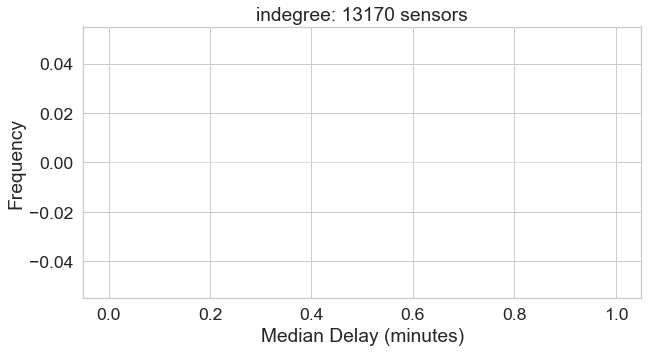

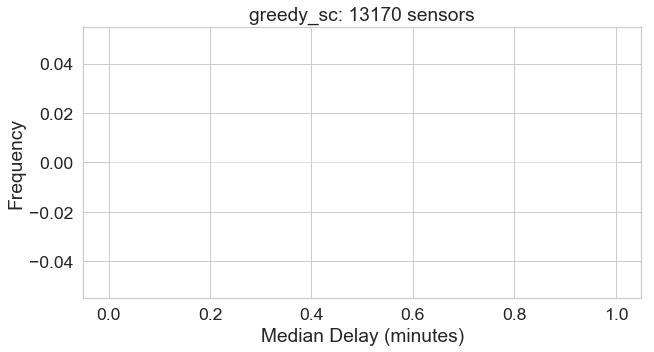

In [34]:
import math
#fig, axarr = plt.subplots(figsize=(15,5), nrows=math.ceil(len(cities)/2), ncols=1)
#plt.subplots_adjust(hspace=0.35, wspace=0.2)

ax = [len(cities)]
i = 0
for k,v in cities.items():
    #row,column = i//2, i%2
    #ax = sns.distplot(v['df1']['Median Delay (minutes)'].dropna(), ax=axarr[row][column], bins= 40, kde=False)
    plt.figure(figsize=(10,5))
    ax = sns.distplot(v['df1']['Median Delay (minutes)'].dropna(), bins= 40, kde=False)
    ax.set_title("{0}: {1} sensors".format(k, len(v['df1'])))

    print ('Mean delay (per sensor) for {}: {}'.format(k, np.nanmean(v['df1']['Mean Delay (minutes)'])))
    print ('Median delay (per sensor) for {}: {}'.format(k, np.nanmedian(v['df1']['Median Delay (minutes)'])))
    print()
    
    ax.set_ylabel('Frequency')
    i +=1
    plt.plot()
#fig.savefig('delays.png', dpi=300)

In [40]:
import math
#fig, axarr = plt.subplots(figsize=(15,5), nrows=math.ceil(len(cities)/2), ncols=1)
plt.subplots_adjust(hspace=0.35, wspace=0.2)

i = 0
for k,v in cities.items():
    plt.figure(figsize=(10,5))
    
    ax = sns.distplot(v['ons_msgs'],  kde=False, bins= 60)
    ax.set_title("{0}: {1} data packets".format(k, len(v['ons_msgs'])))
    #ax.figure.set_size_inches((10,5))
    ax.set_xlabel('Median Delay (minutes)'), ax.set_ylabel('Frequency')
    print ('Mean delay (per packet) for {}: {}'.format(k, np.nanmean(v['ons_msgs'])))
    print ('Median delay (per packet) for {}: {}'.format(k, np.nanmedian(v['ons_msgs'])))
    print()
    
    
    plt.plot()
    
    
    i +=1
#fig.savefig('delays2.png', dpi=300)

KeyError: 'ons_msgs'

<Figure size 432x288 with 0 Axes>

<Figure size 720x360 with 0 Axes>

In [ ]:
i = 0
for k,v in cities.items():
    plt.figure(figsize=(10,5))
    
    a = v['ons_wait_times'][~np.isnan(v['ons_wait_times'])]
    b = v['ons_route_times'][~np.isnan(v['ons_route_times'])]
    
    ax = sns.boxplot(
        x=['Sensor \u2192 Bus','Bus \u2192 Gateway'],
        y=[a, b]
    )
    ax.set_ylabel('Delay (Minutes)')
    ax.figure.set_size_inches((5,5))
    ax.set_title(k + ": Delays for on-route packets")
    ax.figure.savefig('e.png', dpi=300)

    print("For {}".format(k), "\n")
    print(
        "Sensor->Bus \nMean: {0}, Median: {1}".format(
            np.nanmean(v['ons_wait_times']), 
            np.nanmedian(v['ons_wait_times'])
        )
    )
    
    print(
        "Bus->Gateway \nMean: {0}, Median: {1}".format(
            np.nanmean(v['ons_route_times']),
            np.nanmedian(v['ons_route_times'])
        )
    )
    print('\n\n')

In [ ]:
import math
#fig, axarr = plt.subplots(figsize=(15,5), nrows=math.ceil(len(cities)/2), ncols=1)
#plt.subplots_adjust(hspace=0.35, wspace=0.2)

ax = [len(cities)]
i = 0
for k,v in cities.items():
    plt.figure(figsize=(10,5))
    ax = sns.distplot(v['df1']['delivery_rate'].dropna(), bins= 40, kde=False)
    ax.set_title("{0}: {1} sensors".format(k, len(v['df1'])))
    
    print ('Median delivery rate (per sensor) for {}: {}'.format(k, np.nanmedian(v['df1']['delivery_rate'])))
    print ('Cummulative delivery rate for {}: {}'.format(k, v['total_delivered']/v['total_generated']))
    print()
    
    ax.set_xlabel('Delivery Rates')
    ax.set_ylabel('Frequency')
    i +=1
    plt.plot()

#fig.savefig('delays.png', dpi=300)